In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


In [0]:
def read_data(file_path):

    column_names = ['user-id','activity','timestamp','x-axis','y-axis','z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [131]:
dataframe = read_data('sample.csv') 
dataframe.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,7,0,207423362123000,4.48,4.48,-19.80
1,7,0,207421722352000,-1.14,0.38,-19.76
2,7,0,207426651856000,3.21,0.34,-19.76
3,8,0,111711611580000,5.86,18.96,-19.72
4,7,0,207441621705000,9.08,7.97,-19.72


In [132]:
dataframe.dtypes

user-id        int64
activity       int64
timestamp      int64
x-axis       float64
y-axis       float64
z-axis       float64
dtype: object

In [0]:

df_test = dataframe[dataframe['user-id'] > 18]
df_train = dataframe[dataframe['user-id'] <= 18]

target_test = df_test.pop('activity')
target_train = df_train.pop('activity')

XData_test = np.array(df_test.values)
YData_test= np.array(target_test.values)

XData_train = np.array(df_train.values)
YData_train= np.array(target_train.values)



scaling_train = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(XData_train)
XData_train = scaling_train.transform(XData_train)

scaling_test = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(XData_test)
XData_test = scaling_test.transform(XData_test)

# scaler = preprocessing.StandardScaler().fit(XData)
# XData = scaler.transform(XData)

dataset_train = tf.data.Dataset.from_tensor_slices((XData_train, YData_train))
dataset_test = tf.data.Dataset.from_tensor_slices((XData_test, YData_test))

In [0]:
train_dataset = dataset_train.shuffle(len(df_train)).batch(1)
test_dataset = dataset_test.shuffle(len(df_test)).batch(1)

In [0]:
def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
  #  tf.keras.layers.Dense(6, activation='sigmoid')

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [140]:

model = get_compiled_model()

history = model.fit(train_dataset,validation_data =test_dataset, epochs=5)



Train on 12018 steps, validate on 17987 steps
Epoch 1/5
12018/12018 [==============================] - 40s 3ms/step - loss: 0.2205 - acc: 0.9184 - val_loss: 0.8585 - val_acc: 0.8224
Epoch 2/5
12018/12018 [==============================] - 39s 3ms/step - loss: 0.1113 - acc: 0.9631 - val_loss: 1.0003 - val_acc: 0.8382
Epoch 3/5
12018/12018 [==============================] - 39s 3ms/step - loss: 0.0917 - acc: 0.9700 - val_loss: 0.9439 - val_acc: 0.8114
Epoch 4/5
12018/12018 [==============================] - 39s 3ms/step - loss: 0.0815 - acc: 0.9734 - val_loss: 1.0577 - val_acc: 0.7949
Epoch 5/5
12018/12018 [==============================] - 39s 3ms/step - loss: 0.0732 - acc: 0.9768 - val_loss: 0.8594 - val_acc: 0.8380


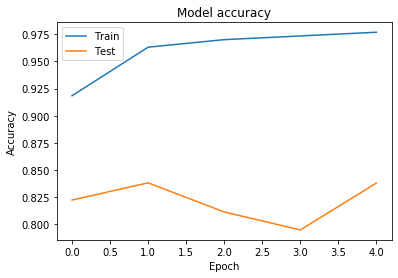

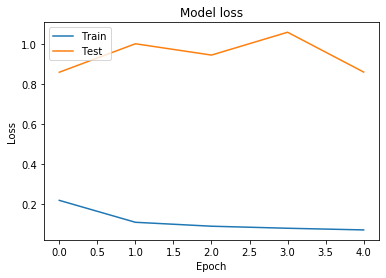

In [141]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


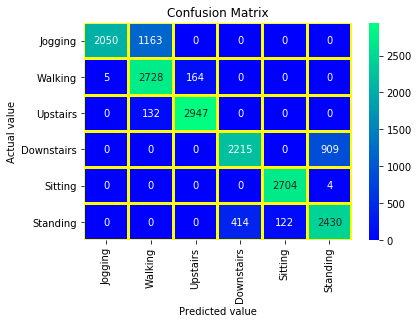

In [142]:
from sklearn import metrics
import seaborn as sns

LABELS = ['Jogging',
          'Walking',
          'Upstairs',
          'Downstairs',
          'Sitting',
          'Standing']
def display_confusion_matrix(test, predict):

    con = metrics.confusion_matrix(test, predict)
    plt.figure(figsize=(6, 4))
    sns.heatmap(con,
                cmap='winter',
                linecolor='yellow',
                linewidths=2,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual value')
    plt.xlabel('Predicted value')
    plt.show()

y_pred_test=model.predict_classes(XData_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = tf.argmax(y_pred_test, axis=1, output_type=tf.int32)
max_y_test = tf.argmax(YData_test,axis=1, output_type=tf.int32)


display_confusion_matrix(y_pred_test, YData_test)
